# Task VI DEEPLENSE (a) Foundation Model
 Train a Masked Autoencoder (MAE) on the no_sub samples from the provided dataset to learn a feature representation of strong lensing images. The MAE should be trained for reconstructing masked portions of input images. Once this pre-training phase is complete, fine-tune the model on the full dataset for a multi-class classification task to distinguish between the three classes. Please implement your approach in PyTorch or Keras and discuss your strategy.



In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import transforms
import numpy as np
import os
import math
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from timm.models.vision_transformer import PatchEmbed, Block


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**Input Adaptation:**
* Modified for 64x64 grayscale images (original MAE uses 224x224 RGB)
* Smaller patch size (8x8 vs original 16x16)
* Adjusted embedding dimensions (128 vs original 768)

In [3]:

# Dataset class ; modified to handle resizing
class StrongLensingDataset(Dataset):
    def __init__(self, root_dir, class_filter=None, img_size=64):
        self.root_dir = root_dir
        self.samples = []
        self.class_map = {"no_sub": 0, "cdm": 1, "axion": 2}
        self.class_counts = {0: 0, 1: 0, 2: 0}
        self.img_size = img_size
        
        if class_filter is not None:
            class_filter = [self.class_map[c] for c in class_filter]
        
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.endswith(".npy"):
                        file_path = os.path.join(class_dir, file_name)
                        image_data = np.load(file_path, allow_pickle=True)
                        
                        if isinstance(image_data, np.ndarray) and image_data.ndim >= 2 and image_data.dtype != np.object_:
                            image = image_data
                        elif isinstance(image_data, np.ndarray) and image_data.dtype == np.object_:
                            extracted_arrays = [arr for arr in image_data if isinstance(arr, np.ndarray) and arr.ndim >= 2]
                            if extracted_arrays:
                                image = extracted_arrays[0]  
                            else:
                                continue  
                        else:
                            continue  
                        
                        if image.ndim > 2:
                            image = image[:, :, 0]  
                        
                        # Resize image if needed
                        if image.shape[0] != self.img_size or image.shape[1] != self.img_size:
                            image = self.resize_image(image, self.img_size)
                        
                        image = (image - np.min(image)) / (np.max(image) - np.min(image))
                        label = self.class_map[class_name]
                        
                        if class_filter is None or label in class_filter:
                            self.samples.append((image, label))
                            self.class_counts[label] += 1

        print(f"Number of valid samples in {root_dir}: {len(self.samples)}")
        print(f"Class distribution: {self.class_counts}")

    def resize_image(self, image, target_size):
        # Simple resize using numpy (for demonstration)
        from scipy.ndimage import zoom
        zoom_factors = (target_size/image.shape[0], target_size/image.shape[1])
        return zoom(image, zoom_factors)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Keep as single channel
        return image, label


## Masked Autoencoder
The MAE is a self-supervised vision transformer that learns by reconstructing randomly masked portions of input images. Great blog I used to study for [MAe](https://medium.com/dair-ai/papers-explained-28-masked-autoencoder-38cb0dbed4af) . MAE consists of : 
An encoder that processes visible patches , A decoder that reconstructs masked patches , A masking strategy.

In [4]:

# Modified MAE Model 
class MAE(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_chans=1,
                 embed_dim=128, depth=8, num_heads=8,
                 decoder_embed_dim=64, decoder_depth=4, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        # Encoder parameters
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), 
                                      requires_grad=False)
        
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        
        # Decoder parameters
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), 
                                            requires_grad=False)
        
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])
        
        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)
        
        self.norm_pix_loss = norm_pix_loss
        
        self.initialize_weights()
    
    def initialize_weights(self):
        # Initialize position embeddings
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], 
                                           int(self.patch_embed.num_patches**0.5),
                                           cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        
        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1],
                                                   int(self.patch_embed.num_patches**0.5),
                                                   cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))
        
        # Initialize patch embedding
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        
        # Initialize tokens
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)
        
        # Initialize linear layers
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def patchify(self, imgs):
        
        # imgs: (N, 1, H, W)
        # x: (N, L, patch_size**2 *1)
        
        p = self.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        
        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 1))
        return x
    
    def unpatchify(self, x):
        
        # x: (N, L, patch_size**2 *1)
        # imgs: (N, 1, H, W)
        
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs
    
    def random_masking(self, x, mask_ratio):
        
        # Perform per-sample random masking by per-sample shuffling.
        # Per-sample shuffling is done by argsort random noise.
        # x: [N, L, D], sequence
        
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)
        
        return x_masked, ids_restore, mask
    
    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)
        
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]
        
        # masking: length -> length * mask_ratio
        x, ids_restore, mask = self.random_masking(x, mask_ratio)
        
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, ids_restore, mask
    
    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)
        
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token
        
        # add pos embed
        x = x + self.decoder_pos_embed
        
        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        
        # predictor projection
        x = self.decoder_pred(x)
        
        # remove cls token
        x = x[:, 1:, :]
        
        return x
    
    def forward(self, imgs, mask_ratio=0.75):
        latent, ids_restore, mask = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        target = self.patchify(imgs)
        
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5
        
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        
        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss, pred, mask


In [5]:
# Helper functions 
#  Generates 1D sine/cosine positional embeddings
# Creates transformer-friendly position information
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)
    grid = np.stack(grid, axis=0)
    
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

# Extends 1D to 2D positional embeddings
# Preserves spatial relationships between patches
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])
    
    emb = np.concatenate([emb_h, emb_w], axis=1)
    return emb

# Final wrapper for 2D positional embeddings
# Generates grid coordinates automatically
# Handles CLS token optionally
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega
    
    pos = pos.reshape(-1)
    out = np.einsum('m,d->md', pos, omega)
    
    emb_sin = np.sin(out)
    emb_cos = np.cos(out)
    
    emb = np.concatenate([emb_sin, emb_cos], axis=1)
    return emb


**Training Strategy to avoid overfitting** 
* Phase 1: Pre-training on no_sub: <br>
Trained only on clean lensing images (no substructure)<br>
75% random masking (aggressive - forces robust feature learning)<br>
Reconstruction target: normalized pixel values<br>
Loss: Mean squared error on masked patches<br>

* Phase 2: Fine-tuning for Classification
Replaced decoder with classification head<br>
Used all three classes (no_sub, cdm, axion)<br>
Balanced training via weighted sampling<br>
Initialized with pre-trained encoder weights<br>

In [6]:

# MAE Training function 
def train_mae(model, dataloader, optimizer, epochs=10, mask_ratio=0.75):
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
        total_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)
            
            optimizer.zero_grad()
            loss, pred, mask = model(images, mask_ratio)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"MAE Pre-training Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Classification Model using MAE encoder 
class MAEClassifier(nn.Module):
    def __init__(self, mae_model, num_classes=3):
        super().__init__()
        # Use the encoder from MAE
        self.patch_embed = mae_model.patch_embed
        self.cls_token = mae_model.cls_token
        self.pos_embed = mae_model.pos_embed
        self.blocks = mae_model.blocks
        self.norm = mae_model.norm
        
        # Classification head
        self.head = nn.Linear(mae_model.pos_embed.shape[-1], num_classes)
        
    def forward(self, x):
        # Embed patches
        x = self.patch_embed(x)
        
        # Add position embedding
        x = x + self.pos_embed[:, 1:, :]
        
        # Append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        # Use cls token for classification
        x = x[:, 0]
        
        return self.head(x)

# Training function for classifier 
def train_classifier(model, train_loader, val_loader, optimizer, epochs=10):
    model.train()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_mae_classifier.pth')
    
    print(f"Training complete. Best Val Acc: {best_val_acc:.2f}%")

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [7]:


# ROC and AUC evaluation 
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    class_names = ['no_sub', 'cdm', 'axion']

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        if np.sum(all_labels == i) > 0 and np.sum(all_labels != i) > 0:
            fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            print(f'{class_name} AUC: {roc_auc:.2f}')
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        else:
            print(f'{class_name} AUC: Not enough samples to calculate')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


**Implementations:**
* Positional Encoding: Uses learned 2D sine-cosine positional embeddings, Critical for understanding patch relationships.
* Masking Strategy
* Reconstruction Target: Normalized patches (optionally with mean/std normalization), Only computes loss on masked patches

Number of valid samples in /kaggle/input/dataset/Dataset: 89104
Class distribution: {0: 29449, 1: 29759, 2: 29896}
Number of valid samples in /kaggle/input/dataset/Dataset: 29449
Class distribution: {0: 29449, 1: 0, 2: 0}
Pre-training MAE on no_sub samples...
MAE Pre-training Epoch 1/20, Loss: 0.0296
MAE Pre-training Epoch 2/20, Loss: 0.0082
MAE Pre-training Epoch 3/20, Loss: 0.0069
MAE Pre-training Epoch 4/20, Loss: 0.0065
MAE Pre-training Epoch 5/20, Loss: 0.0060
MAE Pre-training Epoch 6/20, Loss: 0.0052
MAE Pre-training Epoch 7/20, Loss: 0.0044
MAE Pre-training Epoch 8/20, Loss: 0.0028
MAE Pre-training Epoch 9/20, Loss: 0.0018
MAE Pre-training Epoch 10/20, Loss: 0.0013
MAE Pre-training Epoch 11/20, Loss: 0.0011
MAE Pre-training Epoch 12/20, Loss: 0.0009
MAE Pre-training Epoch 13/20, Loss: 0.0008
MAE Pre-training Epoch 14/20, Loss: 0.0007
MAE Pre-training Epoch 15/20, Loss: 0.0006
MAE Pre-training Epoch 16/20, Loss: 0.0005
MAE Pre-training Epoch 17/20, Loss: 0.0005
MAE Pre-training E

<ipython-input-8-4947e80bc72d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('best_mae_classifier.pth'))


no_sub AUC: 0.99
cdm AUC: 0.95
axion AUC: 0.97


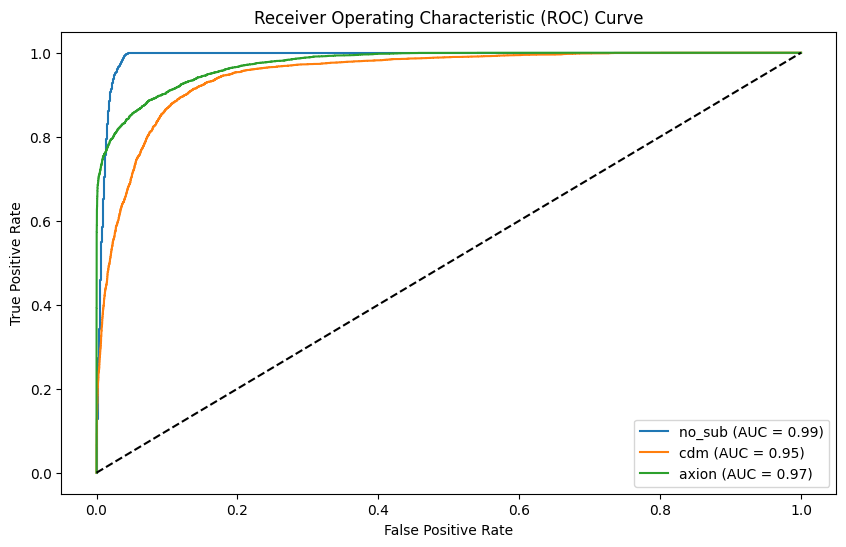

In [8]:

# Main execution
if __name__ == "__main__":
    # Load dataset with 64x64 images
    dataset_path = '/kaggle/input/dataset/Dataset'
    img_size = 64  # Matching your input size
    
    # First create full dataset to see class distribution
    full_dataset = StrongLensingDataset(dataset_path, img_size=img_size)
    
    # Create dataset with only no_sub samples for MAE pre-training
    no_sub_dataset = StrongLensingDataset(dataset_path, class_filter=["no_sub"], img_size=img_size)
    no_sub_loader = DataLoader(no_sub_dataset, batch_size=64, shuffle=True, num_workers=4)
    
    # Initialize MAE model with correct image size
    mae = MAE(img_size=img_size, patch_size=8, in_chans=1)
    
    # Pre-train MAE on no_sub samples
    print("Pre-training MAE on no_sub samples...")
    optimizer = optim.AdamW(mae.parameters(), lr=1.5e-4, weight_decay=0.05)
    train_mae(mae, no_sub_loader, optimizer, epochs=20)
    
    # Create classifier using pre-trained MAE encoder
    classifier = MAEClassifier(mae)
    
    # Create train/val splits from full dataset
    dataset_size = len(full_dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
    # Create weighted samplers to handle class imbalance
    train_labels = [full_dataset.samples[i][1] for i in train_dataset.indices]
    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[train_labels]
    train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    # Fine-tune classifier on full dataset
    print("Fine-tuning classifier on full dataset...")
    optimizer = optim.AdamW(classifier.parameters(), lr=3e-4, weight_decay=0.05)
    train_classifier(classifier, train_loader, val_loader, optimizer, epochs=15)
    
    # Load best model and evaluate
    classifier.load_state_dict(torch.load('best_mae_classifier.pth'))
    print("Evaluating best model on validation set...")
    evaluate_model(classifier, val_loader)

In [9]:
torch.save(classifier.state_dict(), 'mae_classifier.pth')

This task was challenging and intresting for me and took a great time and research to pick best approach. Because axion dataset was inhomogenous while cdm and no_sub dataset were perfect. Then we tried slicing and reshaping of numpy arrays. After that model was not performing well and give outputs for 'random guessing'. Then I try to integrate resnet model which solves before issues but there was over fitting of model. After all that then i picked up this approach. 

We used **Two phase training** approach. 

* Phase 1 (Pre-training): The MAE is trained only on no_sub samples (29,449 images) to learn general features of strong lensing images without substructure.

* Phase 2 (Fine-tuning): The classifier (using the pre-trained encoder) is then trained on all three classes (no_sub, cdm, and axion - total 89,104 images).
<br>
Why This Works: The pre-training learns general image features that are useful for all classes, The fine-tuning then specializes these features for the classification task, This is similar to how models like BERT are pre-trained on general text before being fine-tuned for specific tasks

**Improvements done from previous approaches:**
* Better Spatial Understanding: Transformers > CNNs for long-range dependencies, Crucial for analyzing lensing patterns

* Data Efficiency: Uses unlabeled data via self-supervision, Even labeled data gets used twice (pre-train + fine-tune)

* Adaptability: Easier to adjust for different input sizes, More flexible architecture for future modifications

* Better accuracy, in less time and resources, without over fitting